In [1]:
import os
import torch
import scib
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.sparse as sp
from sklearn import metrics
import multiprocessing as mp
from GraphST import GraphST
# from GraphST_1 import GraphST as GS1
from h5py import File

2025-05-14 15:05:24.743844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 15:05:24.743879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 15:05:24.744747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 15:05:25.302663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/root/.local/lib/python3.10/site-packages/GraphST-1.1.1-py3.10.egg/GraphST/preprocess.py:10: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.c

In [2]:
import anndata2ri

<h1>image read function for visualization</h1>

In [3]:
from matplotlib.image import imread
import json
from pathlib import Path, PurePath

def put_image(adata, path, library_id, arr_col=True):
    path = path + '/' + library_id
    source_image_path = path + '/' + str(library_id)
    adata.uns["spatial"] = dict()
    # from h5py import File
    
    # with File(path / count_file, mode="r") as f:
    #     attrs = dict(f.attrs)
    # if library_id is None:
    #     library_id = str(attrs.pop("library_ids")[0], "utf-8")
    adata.uns["spatial"][library_id] = dict()
    tissue_positions_file = path + "/spatial/tissue_positions_list.csv"
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=path + "/spatial/scalefactors_json.json",
        hires_image=path + "/spatial/tissue_hires_image.png",
        lowres_image=path + "/spatial/tissue_lowres_image.png",
    )
    # check if files exists, continue if images are missing
    # for f in files.values():
    #     if not f.exists():
    #         if any(x in str(f) for x in ["hires_image", "lowres_image"]):
    #             logg.warning(
    #                 f"You seem to be missing an image file.\n"
    #                 f"Could not find '{f}'."
    #             )
    #         else:
    #             raise OSError(f"Could not find '{f}'")
    
    adata.uns["spatial"][library_id]["images"] = dict()
    # for res in ["hires", "lowres"]:
    for res in ["lowres"]:
        try:
            adata.uns["spatial"][library_id]["images"][res] = imread(
                str(files[f"{res}_image"])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")
    
    # read json scalefactors
    adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
        Path(files["scalefactors_json_file"]).read_text()
    )
    
    # adata.uns["spatial"][library_id]["metadata"] = {
    #     k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #     for k in ("chemistry_description", "software_version")
    #     if k in attrs
    # }
    
    # read coordinates
    positions = pd.read_csv(
        files["tissue_positions_file"],
        header= None,
        index_col=0,
    )
    positions.columns = [
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_col_in_fullres",
        "pxl_row_in_fullres",
    ]
    if arr_col:
        adata.obs = adata.obs.join(positions, how="left")
        
        adata.obsm["spatial"] = adata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
        adata.obs.drop(
            columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )
    
    # put image path in uns
    # if source_image_path is not None:
    #     # get an absolute path
    #     source_image_path = str(Path(source_image_path).resolve())
    #     adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
    #         source_image_path
    #     )

    return adata

In [4]:
os.getcwd()

'/workspace/volume/spatial_integration/Spatial_Integration_GSI'

In [5]:
import warnings
warnings.simplefilter("ignore")

<h1>Data Loading</h1>

In [6]:
datasets = ['151507', '151672', '151673']
# datasets = ['anterior_section1', 'posterior_section1']
# datasets = ['coronal_section1', 'coronal_section2']
# dat = "feather"
GN_data = 'com3all' # output of step 5, ['com3all', 'DLPFC', 'coronal']

GNs = f"beer_embed_all_{GN_data}"
GNs_default = f"beer_default_embed_all_{GN_data}"
GN_harmony = f"Harmony_default_embed_all_{GN_data}"
GN_harmony_sp = f"Harmony_sp_embed_all_{GN_data}"

data_folder = "/workspace/volume/spatial_integration/dataset/GraphST/DLPFC/samples"
mouse_folder = "/workspace/volume/spatial_integration/dataset/GraphST/mouse_brain"
new_folder = "/workspace/volume/spatial_integration/GNN_based/combined/processed_data/"
h5_folder = "/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/samples/"
h5_folder_ex = "/workspace/volume/spatial_integration/GNN_based/combined/beer_export/"


dataset_folder = "/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/"
label_folder = "/workspace/volume/spatial_integration/GNN_based/combined/DLPFC_ground/"

In [7]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [8]:
# get beer processed seurat object in anndata format
# beer = sc.read_h5ad('/workspace/volume/spatial_integration/GNN_based/combined/beer_export/240624_com3all_beer.h5ad')
beer = sc.read_h5ad(h5_folder + GNs +'.h5ad')

In [9]:
# get beer processed seurat object in anndata format
# beer = sc.read_h5ad('/workspace/volume/spatial_integration/GNN_based/combined/beer_export/240624_com3all_beer.h5ad')
beer_default = sc.read_h5ad(h5_folder + GNs_default +'.h5ad')

<h1>GraphST combine</h1>

In [10]:
beer_active = {}
for i, dataset in enumerate(datasets):
    beer_active[dataset] = beer[beer.obs['batch_numeric']==i+1]

In [11]:
data_folder

'/workspace/volume/spatial_integration/dataset/GraphST/DLPFC/samples'

In [12]:
new_beer_active = {}
beer_active_combine = {}
adata_test = {}
adata_true = {}

for dataset in datasets:
    dataset_folder = data_folder + '/' + dataset + '/'
    
    adata_true[dataset] = sc.read_visium(dataset_folder, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata_true[dataset].var_names_make_unique()
    
    beer_active[dataset].obs.index = adata_true[dataset].obs.index 
    beer_active[dataset] = put_image(beer_active[dataset], data_folder, dataset)
    
    beer_active_combine[dataset] = beer_active[dataset].copy()

    

In [13]:
layer_labels = {}
for dataset in datasets:
    layer_labels = pd.read_csv(label_folder + f'layer_{dataset}_pos.csv')
    layer_labels = layer_labels['layer_guess'].values
    # layer_labels = beer_active[dataset].obs['orig.ident']
    
    adata_true[dataset].obs['ground_truth'] = layer_labels
    beer_active[dataset].obs['ground_truth'] = layer_labels
    beer_active_combine[dataset].obs['ground_truth'] = layer_labels

<h2>run graphst</h2>

In [14]:
for dataset in datasets:
    print(f'training adata_true for {dataset}')
    model = GraphST.GraphST(adata_true[dataset], device=device)
    adata_true[dataset] = model.train()

training adata_true for 151507
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:15<00:00, 39.75it/s]


Optimization finished for ST data!
training adata_true for 151672
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 79.88it/s]


Optimization finished for ST data!
training adata_true for 151673
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 89.39it/s]

Optimization finished for ST data!


In [15]:
adata_true

{'151507': AnnData object with n_obs × n_vars = 4226 × 33538
     obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'spatial', 'hvg', 'log1p'
     obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb',
 '151672': AnnData object with n_obs × n_vars = 4015 × 33538
     obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'spatial', 'hvg', 'log1p'
     obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb',
 '151673': AnnData object with n_obs × n_vars = 3639 × 33538
     obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_va

In [16]:
os.environ['R_HOME'] = '/usr/lib/R'

In [17]:
from GraphST.utils import clustering

radius = 50
tool = 'mclust' # mclust, leiden, and louvain

for dataset in datasets:

    if GN_data == 'coronal':
        n_clusters = 15
    elif dataset =='151672':
        n_clusters = 5
    else:
        n_clusters = 7

    if tool == 'mclust':
        clustering(adata_true[dataset], n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
    elif tool in ['leiden', 'louvain']:
        clustering(adata_true, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)
    
        

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


<h2>Results Visualization</h2>

<h3>GraphST</h3>

Dataset: 151507
ARI:  0.37427841137458406


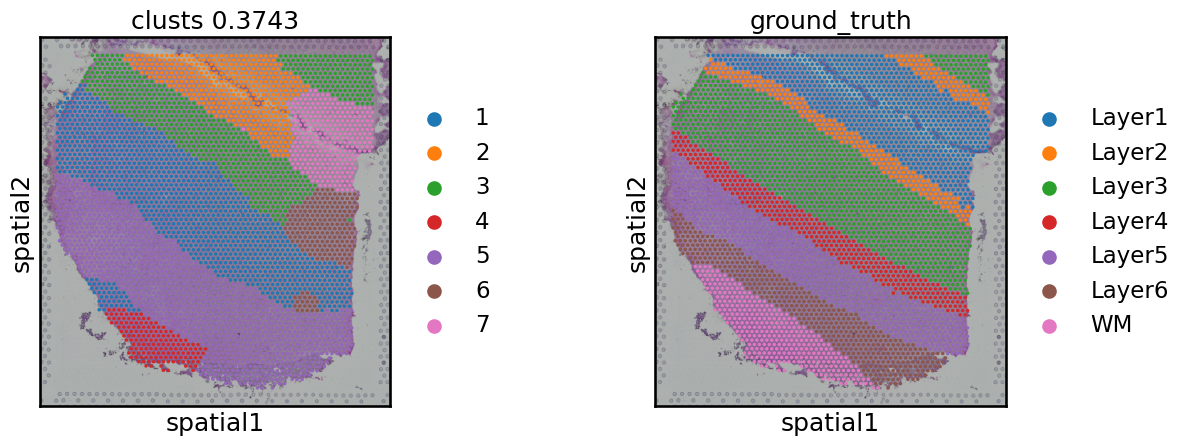

Dataset: 151672
ARI:  0.6144033080565694


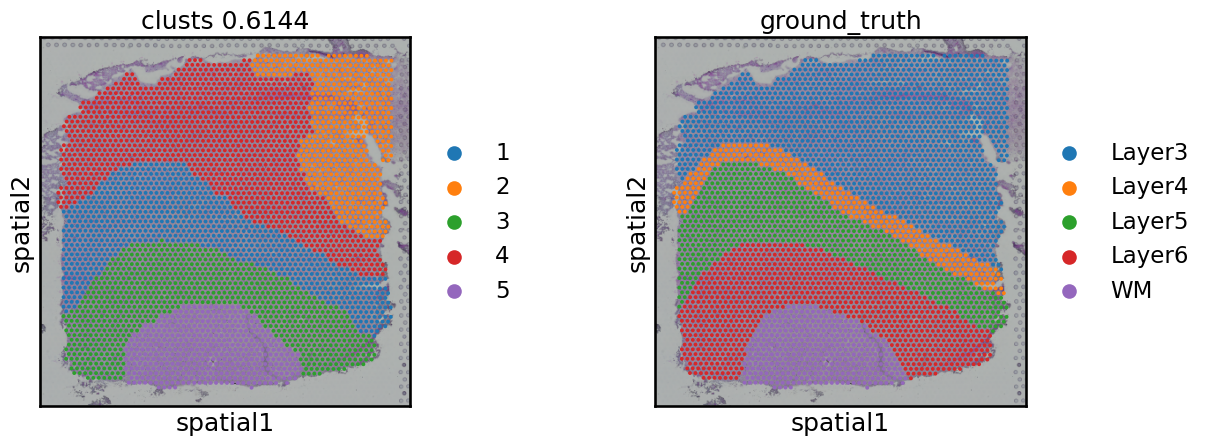

Dataset: 151673
ARI:  0.6363766869926416


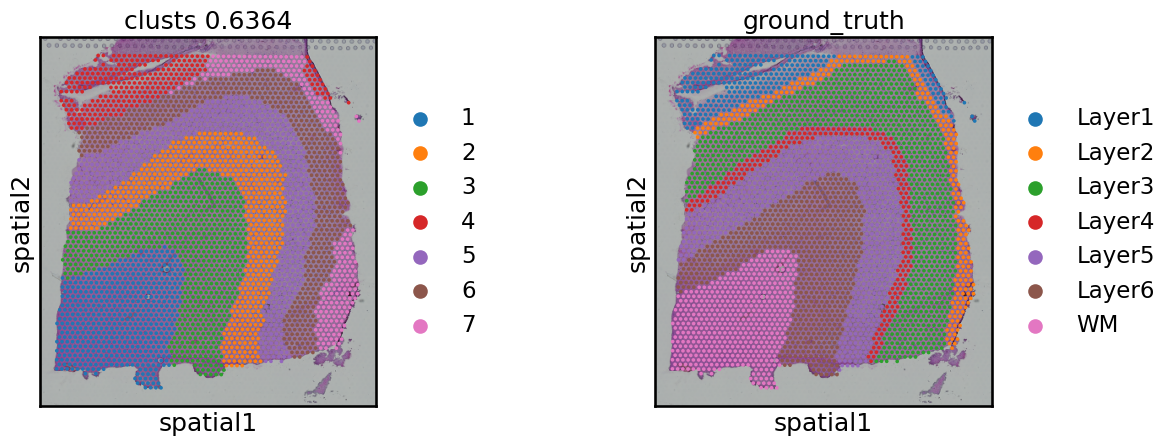

In [18]:
for dataset in datasets:
    adata_true[dataset] = adata_true[dataset][~pd.isnull(adata_true[dataset].obs['ground_truth'])]

    ARI = metrics.adjusted_rand_score(adata_true[dataset].obs['domain'], adata_true[dataset].obs['ground_truth'])
    adata_true[dataset].uns['ARI'] = ARI
    
    print('Dataset:', dataset)
    print('ARI: ', ARI)

    sc.pl.spatial(adata_true[dataset], img_key='lowres',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
              save=None)

<h3>GraphST + GSI</h3>

In [19]:
# separate test using our pipeline output reprocessed with GraphST (combined)
for dataset in datasets:
    beer_active_combine[dataset].var['highly_variable']= True
    
    model3 = GraphST.GraphST(beer_active_combine[dataset], device=device, dim_input=3609) #, dim_input=4015
    beer_active_combine[dataset] = model3.train()

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 90.51it/s]


Optimization finished for ST data!
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 92.92it/s]


Optimization finished for ST data!
Begin to train ST data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 105.59it/s]

Optimization finished for ST data!


In [20]:
for dataset in datasets:
    if dataset =='151672':
        n_clusters = 5
    else:
        n_clusters = 7
        
    if tool == 'mclust':
       clustering(beer_active_combine[dataset], n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
    elif tool in ['leiden', 'louvain']:
       clustering(beer_active_combine[dataset], n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


Dataset: 151507
ARI:  0.5336467145485996


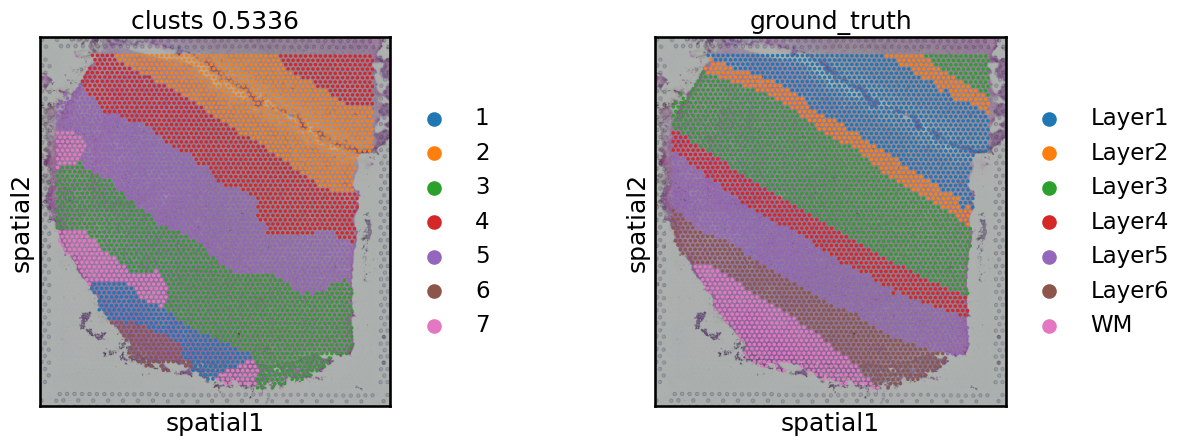

Dataset: 151672
ARI:  0.7951015209180515


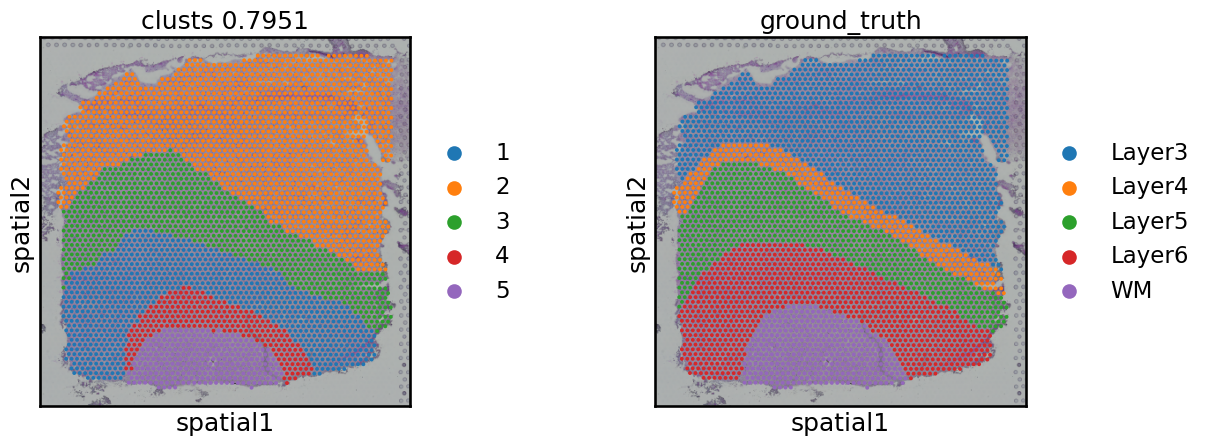

Dataset: 151673
ARI:  0.5746154739533702


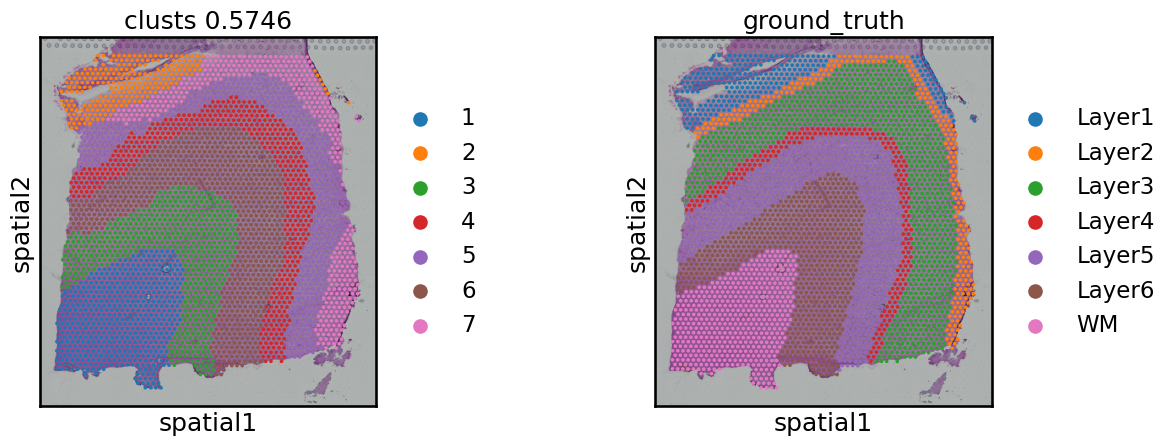

In [21]:
for dataset in datasets:
    beer_active_combine[dataset] = beer_active_combine[dataset][~pd.isnull(beer_active_combine[dataset].obs['ground_truth'])]
    
    ARI = metrics.adjusted_rand_score(beer_active_combine[dataset].obs['domain'], beer_active_combine[dataset].obs['ground_truth'])
    beer_active_combine[dataset].uns['ARI']=ARI
    
    print('Dataset:', dataset)
    print('ARI: ', ARI)

    sc.pl.spatial(beer_active_combine[dataset], img_key='lowres',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
             save=None) #'151673_combinedwbeer.png'
                                

<h1>SCIB Benchmark</h1>

In [22]:
combined_ad_true = ad.concat(adata_true, axis = 0, label='source', merge='same')

In [23]:
combined_ad = ad.concat(beer_active_combine, axis = 0, label='source', merge='same')

<h2>Seurat + Beer</h2>

<h5>ARI</h5>

In [24]:
scib.metrics.ari(beer_default,cluster_key='seurat_clusters',label_key='orig.ident')

0.16051152730332066

In [25]:
scib.metrics.ari(beer_default[beer_default.obs['batch_numeric']==1],cluster_key='seurat_clusters',label_key='orig.ident')

0.21859452021717668

In [26]:
scib.metrics.ari(beer_default[beer_default.obs['batch_numeric']==2],cluster_key='seurat_clusters',label_key='orig.ident')

0.18268260926545948

In [27]:
scib.metrics.ari(beer_default[beer_default.obs['batch_numeric']==3],cluster_key='seurat_clusters',label_key='orig.ident')

0.22184308602731254

<h5>NMI</h5>

In [28]:
scib.metrics.nmi(beer_default,cluster_key='seurat_clusters',label_key='orig.ident')

0.26212062558086513

In [29]:
scib.metrics.nmi(beer_default[beer_default.obs['batch_numeric']==1],cluster_key='seurat_clusters',label_key='orig.ident')

0.31769015480548385

In [30]:
scib.metrics.nmi(beer_default[beer_default.obs['batch_numeric']==2],cluster_key='seurat_clusters',label_key='orig.ident')

0.24075333902018395

In [31]:
scib.metrics.nmi(beer_default[beer_default.obs['batch_numeric']==3],cluster_key='seurat_clusters',label_key='orig.ident')

0.3229481997583187

<h5>ASW</h5>

In [32]:
scib.metrics.silhouette(beer_default,label_key='orig.ident',embed='X_pca')

0.48760088283829167

<h5>clisi</h5>

In [33]:
scib.metrics.clisi_graph(beer_default, label_key="ident_numeric", type_='embed', use_rep="X_pca")

0.7580637085701023

<h5>isolated f1</h5>

In [34]:
scib.metrics.isolated_labels_f1(beer_default, label_key='orig.ident', batch_key='batch', embed='X_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Recompute neighbors on rep X_pca instead of None
Cluster for iso_label_0.2 with leiden
resolution: 0.2, max_f1: 0.5463774803876327
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.5964467005076142
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.7186472522310944
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.686436982119494
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.687582854617764
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.6368613138686132
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.7058823529411765
Cluster for iso_label_1.6 with leiden
resolution: 1.6, max_f1: 0.7004264392324093
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.6915887850467289
Cluster for iso_label_2.0 with leiden
resolution: 2.0, max_f1: 0.6936936936936937
optimised clustering against orig.ident
optim

0.44187750980810514

<h5>isolated asw</h5>

In [35]:
scib.metrics.isolated_labels_asw(beer_default, label_key='orig.ident', batch_key='batch', embed='X_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Layer1: 0.4676072350473654
Layer2: 0.50082229691491


0.48421476598113766

<h5>ilisi</h5>

In [36]:
scib.metrics.ilisi_graph(beer_default, batch_key="batch", type_='embed', use_rep="X_pca")

0.7334427615969723

<h5>Batch ASW</h5>

In [37]:
scib.metrics.silhouette_batch(beer_default,batch_key='batch',label_key='orig.ident',embed='X_pca', scale=True)

mean silhouette per group:         silhouette_score
group                   
Layer1          0.927216
Layer2          0.884110
Layer3          0.973382
Layer4          0.961249
Layer5          0.968576
Layer6          0.958949
NA              0.926576
WM              0.867193


0.9334064264136708

<h5>kBET</h5>

In [38]:
scib.metrics.kBET(beer_default, batch_key="batch", label_key="ident_numeric", type_="embed", embed="X_pca")

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 4


0.23002863834184417

<h5>graph connectivity</h5>

In [39]:
beer_default.obs['ident_numeric_cat'] = beer_default.obs['ident_numeric'].copy().astype('category')
sc.pp.neighbors(beer_default, use_rep="X_pca")
scib.metrics.graph_connectivity(beer_default, label_key='ident_numeric_cat')

0.8553763841268279

---

<h2>GSI</h2>

<h5>ARI</h5>

In [40]:
scib.metrics.ari(beer,cluster_key='seurat_clusters',label_key='orig.ident')

0.24702241801204797

In [41]:
scib.metrics.ari(beer[beer.obs['batch_numeric']==1],cluster_key='seurat_clusters',label_key='orig.ident')

0.24923649054177507

In [42]:
scib.metrics.ari(beer[beer.obs['batch_numeric']==2],cluster_key='seurat_clusters',label_key='orig.ident')

0.2598770058413997

In [43]:
scib.metrics.ari(beer[beer.obs['batch_numeric']==3],cluster_key='seurat_clusters',label_key='orig.ident')

0.38373054270649276

<h5>NMI</h5>

In [44]:
scib.metrics.nmi(beer,cluster_key='seurat_clusters',label_key='orig.ident')

0.34547004223897876

In [45]:
scib.metrics.nmi(beer[beer.obs['batch_numeric']==1],cluster_key='seurat_clusters',label_key='orig.ident')

0.34651056783399486

In [46]:
scib.metrics.nmi(beer[beer.obs['batch_numeric']==2],cluster_key='seurat_clusters',label_key='orig.ident')

0.3332886815733316

In [47]:
scib.metrics.nmi(beer[beer.obs['batch_numeric']==3],cluster_key='seurat_clusters',label_key='orig.ident')

0.4347774568543794

<h5>ASW</h5>

In [48]:
scib.metrics.silhouette(beer,label_key='orig.ident',embed='X_pca')

0.49483871310916233

<h5>clisi</h5>

In [49]:
scib.metrics.clisi_graph(beer, label_key="ident_numeric", type_='embed', use_rep="X_pca")

0.8073781029020691

<h5>isolated f1</h5>

In [50]:
scib.metrics.isolated_labels_f1(beer, label_key='orig.ident', batch_key='batch', embed='X_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Recompute neighbors on rep X_pca instead of None
Cluster for iso_label_0.2 with leiden
resolution: 0.2, max_f1: 0.3379883885140436
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.3604929818555289
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.38703634319970026
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.6099342585829073
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.5236096537250787
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.5386178861788619
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.7405355493998154
Cluster for iso_label_1.6 with leiden
resolution: 1.6, max_f1: 0.5346534653465347
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.6887254901960784
Cluster for iso_label_2.0 with leiden
resolution: 2.0, max_f1: 0.72487494315598
optimised clustering against orig.ident
opti

0.5625556924376969

<h5>isolated asw</h5>

In [51]:
scib.metrics.isolated_labels_asw(beer, label_key='orig.ident', batch_key='batch', embed='X_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Layer1: 0.531172569428047
Layer2: 0.5306906128666888


0.530931591147368

<h5>ilisi</h5>

In [52]:
scib.metrics.ilisi_graph(beer, batch_key="batch", type_='embed', use_rep="X_pca")

0.6548427160157573

<h5>Batch ASW</h5>

In [53]:
scib.metrics.silhouette_batch(beer,batch_key='batch',label_key='orig.ident',embed='X_pca', scale=True)

mean silhouette per group:         silhouette_score
group                   
Layer1          0.898068
Layer2          0.950011
Layer3          0.933135
Layer4          0.948295
Layer5          0.959398
Layer6          0.966294
NA              0.922105
WM              0.815338


0.9240803451474033

<h5>kBET</h5>

In [54]:
scib.metrics.kBET(beer, batch_key="batch", label_key="ident_numeric", type_="embed", embed="X_pca")

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5


0.21154280838888395

<h5>graph connectivity</h5>

In [55]:
beer.obs['ident_numeric_cat'] = beer.obs['ident_numeric'].copy().astype('category')
sc.pp.neighbors(beer, use_rep="X_pca")
scib.metrics.graph_connectivity(beer, label_key='ident_numeric_cat')

0.8664033457559113

---

<h2>GraphST</h2>

<h5>ARI</h5>

In [56]:
scib.metrics.ari(combined_ad_true,cluster_key='domain',label_key='ground_truth')

0.15028069702599156

In [57]:
scib.metrics.ari(combined_ad_true[combined_ad_true.obs['source']=='151507'],cluster_key='domain',label_key='ground_truth')

0.37427841137458406

In [58]:
scib.metrics.ari(combined_ad_true[combined_ad_true.obs['source']=='151672'],cluster_key='domain',label_key='ground_truth')

0.6144033080565694

In [59]:
scib.metrics.ari(combined_ad_true[combined_ad_true.obs['source']=='151673'],cluster_key='domain',label_key='ground_truth')

0.6363766869926416

<h5>NMI</h5>

In [60]:
scib.metrics.nmi(combined_ad_true,cluster_key='domain',label_key='ground_truth')

0.2879776909798912

In [61]:
scib.metrics.nmi(combined_ad_true[combined_ad_true.obs['source']=='151507'],cluster_key='domain',label_key='ground_truth')

0.5838794581623187

In [62]:
scib.metrics.nmi(combined_ad_true[combined_ad_true.obs['source']=='151672'],cluster_key='domain',label_key='ground_truth')

0.7182670912670066

In [63]:
scib.metrics.nmi(combined_ad_true[combined_ad_true.obs['source']=='151673'],cluster_key='domain',label_key='ground_truth')

0.7345843962297145

<h5>ASW</h5>

In [64]:
scib.metrics.silhouette(combined_ad_true,label_key='ground_truth',embed='emb_pca')

0.4989376028534025

<h5>clisi</h5>

In [65]:
scib.metrics.clisi_graph(combined_ad_true, label_key="ground_truth", type_='embed', use_rep="emb_pca")

0.8634028067151188

<h5>isolated f1</h5>

In [66]:
scib.metrics.isolated_labels_f1(combined_ad_true, label_key='ground_truth', batch_key='source', embed='emb_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Recompute neighbors on rep emb_pca instead of None
Cluster for iso_label_0.2 with leiden
resolution: 0.2, max_f1: 0.4605304212168487
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.7261724659606656
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.7325227963525835
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.735968765251342
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.733847637415622
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.7358490566037736
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.7478696741854637
Cluster for iso_label_1.6 with leiden
resolution: 1.6, max_f1: 0.7369985141158989
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.7394296951819075
Cluster for iso_label_2.0 with leiden
resolution: 2.0, max_f1: 0.7422266800401204
optimised clustering against ground_truth
o

0.5549207525856896

<h5>isolated asw</h5>

In [67]:
scib.metrics.isolated_labels_asw(combined_ad_true, label_key='ground_truth', batch_key='source', embed='emb_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Layer1: 0.5463952571153641
Layer2: 0.5137206399813294


0.5300579485483468

<h5>ilisi</h5>

In [68]:
scib.metrics.ilisi_graph(combined_ad_true, batch_key="source", type_='embed', use_rep="emb_pca")

0.43120031866353026

<h5>Batch ASW</h5>

In [69]:
scib.metrics.silhouette_batch(combined_ad_true,batch_key='source',label_key='ground_truth',embed='emb_pca', scale=True)

mean silhouette per group:         silhouette_score
group                   
Layer1          0.564120
Layer2          0.853307
Layer3          0.941974
Layer4          0.940759
Layer5          0.946452
Layer6          0.935326
WM              0.829903


0.8588342867525016

<h5>kBET</h5>

In [70]:
scib.metrics.kBET(combined_ad_true, batch_key="source", label_key="ground_truth", type_="embed", embed="emb_pca")

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


0.01958671072396123

<h5>graph connectivity</h5>

In [71]:
combined_ad_true.obs['ident_numeric_cat'] = combined_ad_true.obs['ground_truth'].copy().astype('category')

In [72]:
sc.pp.neighbors(combined_ad_true, use_rep="emb_pca")
scib.metrics.graph_connectivity(combined_ad_true, label_key='ident_numeric_cat')

0.9944088091482006

---

<h2>GraphST + GSI</h2>

<h5>ARI</h5>

In [73]:
scib.metrics.ari(combined_ad,cluster_key='domain',label_key='ground_truth')

0.2773414718471344

In [74]:
scib.metrics.ari(combined_ad[combined_ad.obs['batch_numeric']==1],cluster_key='domain',label_key='ground_truth')

0.5336467145485996

In [75]:
scib.metrics.ari(combined_ad[combined_ad.obs['batch_numeric']==2],cluster_key='domain',label_key='ground_truth')

0.7951015209180515

In [76]:
scib.metrics.ari(combined_ad[combined_ad.obs['batch_numeric']==3],cluster_key='domain',label_key='ground_truth')

0.5746154739533701

<h5>NMI</h5>

In [77]:
scib.metrics.nmi(combined_ad,cluster_key='domain',label_key='ground_truth')

0.41258321628148237

In [78]:
scib.metrics.nmi(combined_ad[combined_ad.obs['batch_numeric']==1],cluster_key='domain',label_key='ground_truth')

0.6683786481672256

In [79]:
scib.metrics.nmi(combined_ad[combined_ad.obs['batch_numeric']==2],cluster_key='domain',label_key='ground_truth')

0.7705052314205165

In [80]:
scib.metrics.nmi(combined_ad[combined_ad.obs['batch_numeric']==3],cluster_key='domain',label_key='ground_truth')

0.6982427106491699

<h5>ASW</h5>

In [81]:
scib.metrics.silhouette(combined_ad,label_key='ground_truth',embed='emb_pca')

0.49604920065030456

<h5>clisi</h5>

In [82]:
scib.metrics.clisi_graph(combined_ad, label_key="ground_truth", type_='embed', use_rep="emb_pca")

0.7840435511262988

<h5>isolated f1</h5>

In [83]:
scib.metrics.isolated_labels_f1(combined_ad, label_key='ground_truth', batch_key='source', embed='emb_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Recompute neighbors on rep emb_pca instead of None
Cluster for iso_label_0.2 with leiden
resolution: 0.2, max_f1: 0.42928452579034937
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.40059494298463066
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.716796875
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.7176241480038947
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.7101802240623477
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.7209971236816873
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.7035175879396985
Cluster for iso_label_1.6 with leiden
resolution: 1.6, max_f1: 0.7067462138595685
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.7102161100196464
Cluster for iso_label_2.0 with leiden
resolution: 2.0, max_f1: 0.7043222003929274
optimised clustering against ground_truth
opti

0.5288861710545053

<h5>isolated asw</h5>

In [84]:
scib.metrics.isolated_labels_asw(combined_ad, label_key='ground_truth', batch_key='batch', embed='emb_pca')

isolated labels: no more than 2 batches per label
isolated labels: ['Layer1', 'Layer2']
Layer1: 0.5085673332214355
Layer2: 0.4919060105457902


0.5002366718836129

<h5>ilisi</h5>

In [85]:
scib.metrics.ilisi_graph(combined_ad, batch_key="batch", type_='embed', use_rep="emb_pca")

0.5441866710260432

<h5>Batch ASW</h5>

In [86]:
scib.metrics.silhouette_batch(combined_ad,batch_key='batch',label_key='orig.ident',embed='emb_pca', scale=True)

mean silhouette per group:         silhouette_score
group                   
Layer1          0.623220
Layer2          0.791471
Layer3          0.934447
Layer4          0.939367
Layer5          0.929539
Layer6          0.943632
WM              0.881791


0.8633524840664555

<h5>kBET</h5>

In [87]:
scib.metrics.kBET(combined_ad, batch_key="source", label_key="ground_truth", type_="embed", embed="emb_pca")

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


0.01632629838561428

<h5>graph connectivity</h5>

In [88]:
combined_ad.obs['ident_numeric_cat'] = combined_ad.obs['ident_numeric'].copy().astype('category')

In [89]:
sc.pp.neighbors(combined_ad, use_rep="emb_pca")
scib.metrics.graph_connectivity(combined_ad, label_key='ident_numeric_cat')

0.8919104471472238

---